# Determine perturbation scales
Plot the ERA5 linear regression of the meridional winds and the perturbation wind function to compare the spatial scales of each.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Calulate linear regressions on monthly anomalies
Following the method for calculating standard error as is given on pages 250-254 of Thomson and Emery

In [3]:
v10_dir = '/work/Marion.Alberty/data/ERA5_pp/v_10m/'
flist_v10 = glob(f'{v10_dir}ERA5_monthly_v_10m_*.nc')

In [4]:
def fix_latlon(ds):
    # Rename to lat, lon
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
    # reindex for increasing lat
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    return ds

In [5]:
## Read in observational data
DS_v10 = fix_latlon(xr.open_mfdataset(flist_v10,engine='netcdf4'))

In [6]:
# Set lat,lon for analysis
lats = np.array([50, 80])
lons = np.array([160, 230])

In [7]:
# extract regions for analysis
v10 = DS_v10.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))

In [8]:
def linReg_Mclim(ds):
    def mk_lr(ds,mon):
        # get linear regression coefficients for Jan and initialize dataset
        lr = ds.isel(time=ds.groupby('time.month').groups[mon]).polyfit(
            'time',1,full=True).assign_coords(month=mon).expand_dims('month')
        # rename coefficients
        lr = lr.rename({[s for s in list(lr.keys()) if "coefficients" in s][0]:'b0_b1'})
        # rename sum of squared errors
        lr = lr.rename({[s for s in list(lr.keys()) if "residuals" in s][0]:'SSE'})
        # add sample size
        lr['N'] = (('month'),[len(ds.isel(time=ds.groupby('time.month').groups[mon]).time)])
        # calculate the standard error of the estimate
        lr['s_err'] = (lr['SSE']/(lr['N']-2))**(1/2)
        # calc spread in time
        dt = (ds.isel(time=ds.groupby('time.month').groups[mon]).time - 
              ds.isel(time=ds.groupby('time.month').groups[mon]).time.mean()).astype(float).values
        # calculate the standard error of the slope (dea)
        lr['s_b1'] = lr['s_err']/((dt**2).sum()**(1/2))
        # calc mask for statistical significance
        lr['b1_mask'] = (abs(lr['b0_b1'].sel(degree=1)) < (2*lr['s_b1'])).astype(int)
        return lr
    # get linear regression coefficients for Jan and initialize dataset
    LR = mk_lr(ds,1)
    for i in range(2,13):
        # calc lin regress for next month
        _LR = mk_lr(ds,i)
        # concat with previous months
        LR = xr.concat([LR, _LR],"month")
    return LR

In [9]:
# winds
LRm_v10 = linReg_Mclim(v10).load()

## Calculate the perturbation

$$v^\prime(x,y,t) = v_0 e^{-(\frac{x}{L_x})^2 -(\frac{y}{L_y})^2} v^\prime(t) $$

In [10]:
path_in = '/archive/gold/datasets/reanalysis/JRA55-do/v1.4.0/padded/'
flist = glob(f'{path_in}vas_*.nc')
# Open one file to get lat, lon coordinates
DS = xr.open_mfdataset(flist[6])

In [11]:
# location of perturbation center
lat_p = 68
lon_p = 193
Lx = 300 # [km]
Ly = 500 # [km]
v_0 = 2.5 # [m/s]

In [12]:
# Caclulate the degrees difference from the perturbation
delta_lon = DS['lon'] - lon_p
delta_lat = DS['lat'] - lat_p

In [13]:
# Calculate the distance in km for each grid point from the perturbation
Re = 6.378e3 # radius of earth [km]
y = (Re * (np.pi * delta_lat / 180)).expand_dims(dim={'lon':DS.lon})
x = Re * (np.pi * delta_lon / 180) * np.cos(np.pi * DS.lat / 180)

In [14]:
# Calculate the perturbation as a function of space
v_prime0 = v_0 * np.exp(-(x/Lx)**2 -(y/Ly)**2)

## Plot maps

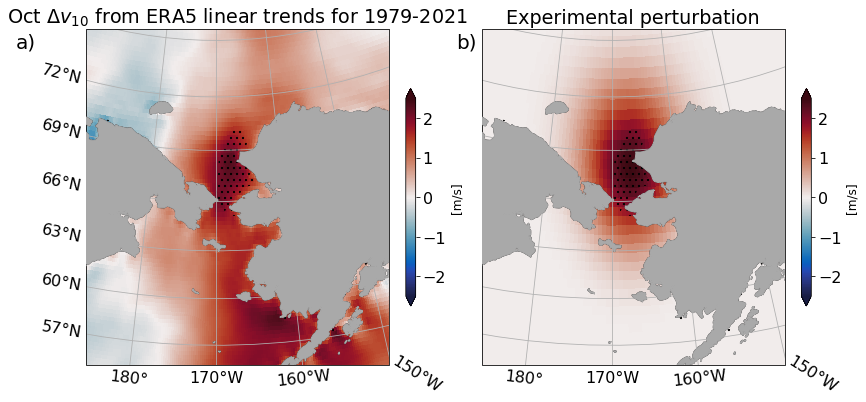

In [15]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(13,7),nrows=1,ncols=2,
                      subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})
# Specify data projection
crs = ccrs.PlateCarree()

# Linear regression map
# convert units of the trend from ns to years
t_con = 1e9 * 86400 * 365.25
dy = v10.time.size/12
# Pull variables for plotting
x0 = LRm_v10['lon']
y0 = LRm_v10['lat']
z0 = dy * t_con * LRm_v10['b0_b1'].sel(degree=1).sel(month=10)
mask0 = LRm_v10['b1_mask'].sel(month=10)

# plot trend
im0 = ax[0].pcolormesh(x0,y0,z0,transform=crs,cmap='cmo.balance',
                      vmin=-v_0,vmax=v_0,rasterized=True)
# add mask from lin reg
n_levels = 1
ax[0].contourf(x0,y0,mask0,n_levels,colors='none',hatches=['..',None],
               transform=crs)

# Zoom in around the Bering Strait
ax[0].set_extent([175, 210, 55, 75], crs=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax[0].add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
gl = ax[0].gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
                     crs=crs,xlocs=[180,-170,-160,-150])
gl.xlabels_top = False
gl.ylabels_right = False
ax[0].coastlines()
ax[0].set_title('Oct $\Delta v_{10}$ from ERA5 linear trends for 1979-2021')

# colorbar
cbar0 = plt.colorbar(im0,ax=ax[0],fraction=0.03,pad=0.05,extend='both')
cbar0.set_label('[m/s]',fontsize=12)

# Perturbation map
# Pull variables for plotting
x1 = v_prime0['lon']
y1 = v_prime0['lat']
z1 = v_prime0.transpose()

# plot perturbation
im1 = ax[1].pcolormesh(x1,y1,z1,transform=crs,cmap='cmo.balance',
                      vmin=-v_0,vmax=v_0,rasterized=True)
# add mask from lin reg
n_levels = 1
ax[1].contourf(x0,y0,mask0,n_levels,colors='none',hatches=['..',None],
               transform=crs)

# Zoom in around the Bering Strait
ax[1].set_extent([175, 210, 55, 75], crs=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax[1].add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
gl = ax[1].gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
                     crs=crs,xlocs=[180,-170,-160,-150])
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax[1].coastlines()
ax[1].set_title('Experimental perturbation')

# colorbar
cbar1 = plt.colorbar(im1,ax=ax[1],fraction=0.03,pad=0.05,extend='both')
cbar1.set_label('[m/s]',fontsize=12)

fig.text(0.05,0.8,'a)',fontsize=20)
fig.text(0.52,0.8,'b)',fontsize=20)

plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/OctDeltaV10fromERA5linearTrend_BWP.pdf')